**Tekstikaeve rakendamine isiksustestidel personali värbamise eesmärgil**

Liset Marleen Pak

Magistritöö

Tartu Ülikool 2018

*1. Andmete sisselugemine ja eeltöötlus

In [2]:
from estnltk import Text
import estnltk
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

c:\users\liset\anaconda3\envs\lmp_thesis\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
#1)Loetakse sisse andmed, kus üks rida = üks dokument
df = pd.read_csv("PIST_analyys_08.05_rida.csv", sep = ";", encoding='utf-8')

NB! Sisseloetud tekstilisi andmeid antud töös ei kuvata, kuna tegu on isiklike ja tundlike andmetega

In [4]:
#Funktsioon numbrite eemaldamiseks tekstist
def numbrid_välja(dokument):
    result = ''.join([i for i in dokument if not i.isdigit()])
    return result

In [5]:
#Funktsioon sõnade asendamiseks etteantud sõnastiku alusel
asendus_dic = {'10 ': 'kümme ', 'vüi': 'või', 'püüjan': 'püüdma', 'luhtne': 'lihtne', 'näudata': 'näidama', 'hiljme': 'hiljem', 'rohkme': 'rohkem', 'aegajalt': 'aeg-ajalt', 'arnguruum': 'arenguruum', 'diskusioon': 'diskussioon', 'ebaõnnestumsiest': 'ebaõnnestumine', 'elliviija': 'elluviija', 'emotsionaalseslt': 'emotsionaalne', 'inidiviid': 'indiviid', 'jub': 'juba', 'kudas': 'kuidas', 'niimõndag': 'mõni', 'prakmaatik': 'pragmaatik', 'rohekem': 'rohkem', 'räägima': 'rääkima', 'väääga': 'väga', 'üldisle': 'üldine', 'üritna': 'üritama'}
def asendamine(asendus_dic, sõne):
    for i in asendus_dic:
        sõne = sõne.replace(i, asendus_dic[i])
    return sõne

In [6]:
#Funktsioon stopp-sõnade eemaldamiseks
stopp_list = ['olukord', 'olema', 'mina', 'see', 'ise', 'siis', ' siis', 'asi', 'mis', 'oma', 'ning', 'jah', 'ei', ' ei', 'inimene', 'selline', 'jne', 'aga', 'tegema', ' tegema', 'väga', ' väga', 'saama', 'teine', 'samas', 'ikka', 'seal', 'kindlasti', 'või', 'kõik', 'alati', 'jaoks', 'pigem', 'pidama', 'et', 'kui', 'ka', 'ja', 'on', 'kuid', 'nii', 'miski', 'kuna', 'mingi', 'nt', 'kuskil', '\x93', '\x84', 'vmt', '.', ' .', ',', ' ,', '%', '-', '=', '+', '"', '(', ')', '!', '?', ':', '..', '...', 'vt', 'a', 'b', 't', ':)', ').', 'ju', 'nr', 'd', ':-)', ':-).', '),', 'sina', 'nö', ';', ' ;', 'tema', 'iga', 'ehk', 'mitte', 'väide', 'sest', '".', '",', '/', 'ca', 'sh', 'nn', 'kes', 'no', 'sh', 's.h', 'st', '...', 'js', 'ku', 'la', 'le', 'n.ö', 'ndat', 'p', 'st', 'vm', 'vms', 'x', 'c', 'er', 'h', 'ii', 'jm', 'jms', 'nr', ':).', '_', '").', '!!', '(:']
def stoppide_eemaldamine(stopp_list, lst):
    temp_lst = []
    for i in lst:
        if i not in stopp_list:
            temp_lst.append(i)
    return temp_lst

In [7]:
#Funktsioon morfoloogilisest analüüsist tingitud püstkriipsude eemaldamiseks (valitakse püstkriipsust vasakule poole jääv sõna)
def kahesus(lst):
    temp_list = []
    for i in lst:
        if '|' in i:
            temp_list.append(i.split('|')[0])
        else: 
            temp_list.append(i)  
    return temp_list

In [9]:
#Funktsioon tekstikorpuse eeltöötluseks, milles on kasutatud eelnevaid abifunktsioone
def preprocessing(dataframe):
    texts_lemmas = [] 
    for i in range(0, len(dataframe)):
        temp_rida = dataframe.iloc[i].str.cat(sep=' ') #eeltöötlus toimub rea ehk dokumendi kaupa.
        temp_rida = temp_rida.lower() #lowercase ehk kasutakse väiketähti
        temp_rida = asendamine(asendus_dic, temp_rida) #asendussõnad
        temp_rida = numbrid_välja(temp_rida) #võetakse numbrid välja
        temp_doc = Text(temp_rida) #rida muudetakse ESTNLTK Text objektiks
        temp_doc = temp_doc.lemmas #teostatakse Text objekti lemmatiseerimine
        temp_doc = stoppide_eemaldamine(stopp_list, temp_doc) #eemaldatakse stopp-sõnad
        temp_doc = kahesus(temp_doc) #lahendatakse sõnad, milles esineb püstkriips
        temp_doc = ' '.join(temp_doc)
        texts_lemmas.append(temp_doc) #sõnad lisatakse listi
    return texts_lemmas

In [10]:
#Luuakse eeltöödeldud tekstikorpus
texts_lemmas = preprocessing(df)
len(texts_lemmas) #listis text_lemmas on 119 dokumenti

119

In [11]:
#olemasolev korpus viiakse üle LDA-mudeli jaoks sobivamale kujule
texts_lemmas_clean = [text.split() for text in texts_lemmas]

*2. LDA-mudeli loomine koos bigrammidega

Kasutatud on mõningaid näiteid järgnevalt lingilt: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [15]:
#bigrammide moodustamine tekstikorpuse põhjal
bigram = gensim.models.Phrases(texts_lemmas_clean, min_count=4, threshold=50) #valitakse bigrammid, mis esinevad korpuses vähemalt neljal korral
bigram_mod = gensim.models.phrases.Phraser(bigram)

#Funktsioon bigrammide moodustamiseks
def moodusta_bigram(tekstid):
    return [bigram_mod[doc] for doc in tekstid]

In [16]:
#Luuakse uus korpus bigrammide jaoks
texts_lemmas_clean_b = moodusta_bigram(texts_lemmas_clean)

In [17]:
#LDA mudel bigrammide jaoks
# Luuakse sõnastik, kus igale unikaalsele sõnale on määratud oma indeks  
lda_dictionary2 = corpora.Dictionary(texts_lemmas_clean_b)

# Dokumentide list (korpus) konverteeritakse dokument-mõiste maatriksiks kasutades eelnevalt loodud sõnastikku
doc_term_matrix2 = [lda_dictionary2.doc2bow(doc) for doc in texts_lemmas_clean_b]

In [19]:
# Luuakse gensim teegi abil LDA mudeli objekt
Lda = gensim.models.ldamodel.LdaModel
# Olemasoleva korpuse põhjal LDA mudeli treenimine 
ldamodel2b = Lda(doc_term_matrix2, num_topics=3, id2word = lda_dictionary2, passes=20, random_state=1)
#selgus, et kõige optimaalsem klastrite ehk teemade arv (num_topics) on 3.

#LDA-mudeli tulemuste visualiseerimine pyLDAvis abil
vis2b = pyLDAvis.gensim.prepare(topic_model = ldamodel2b, corpus = doc_term_matrix2, dictionary = lda_dictionary2)
pyLDAvis.display(vis2b)

In [20]:
print(ldamodel2b.print_topics(num_topics=3, num_words=30)) #saab vaadata teemasid ja selles esineva kõige suurema tõenäosusega sõnu

[(0, '0.010*"tulema" + 0.009*"meeldima" + 0.008*"hea" + 0.008*"töö" + 0.007*"palju" + 0.007*"võima" + 0.007*"aeg" + 0.007*"välja" + 0.006*"elu" + 0.006*"suutma" + 0.006*"ütlema" + 0.006*"teadma" + 0.005*"tundma" + 0.005*"uskuma" + 0.005*"otsus" + 0.005*"tahtma" + 0.004*"oluline" + 0.004*"tunne" + 0.004*"plaan" + 0.004*"uus" + 0.004*"keegi" + 0.004*"jääma" + 0.004*"nägema" + 0.004*"andma" + 0.004*"hästi" + 0.004*"hakkama" + 0.004*"tihti" + 0.004*"rohkem" + 0.004*"ette" + 0.004*"minema"'), (1, '0.010*"meeldima" + 0.010*"töö" + 0.009*"elu" + 0.008*"võima" + 0.008*"hea" + 0.008*"tulema" + 0.007*"teadma" + 0.007*"otsus" + 0.006*"palju" + 0.006*"püüdma" + 0.006*"välja" + 0.006*"ütlema" + 0.005*"andma" + 0.005*"suutma" + 0.005*"hakkama" + 0.005*"rohkem" + 0.005*"aeg" + 0.005*"mõtlema" + 0.004*"tundma" + 0.004*"oluline" + 0.004*"leidma" + 0.004*"plaan" + 0.004*"eesmärk" + 0.004*"lahendus" + 0.004*"võtma" + 0.004*"ära" + 0.004*"arvama" + 0.004*"minema" + 0.004*"nägema" + 0.004*"uus"'), (2, '0.0

In [21]:
#Bigrammide kuvamine, kuna pakkus huvi, millised bigrammid mudelisse sattusid
bigrams_all = lda_dictionary2.token2id
#Tulemus näitab ngramme sõnadena koos nende unikaalse id numbriga
#kokku on 68 bigrammi
num = 0
for key, val in bigrams_all.items():
    if ('_') in key:
        num +=1
        print( key, val)
print(num)

valima_esimene 605
suur_pilt 1730
mitu_pea 1179
aeglane_elustiil 388
järgmine_kord 2349
eesmärk_saavutamine 1194
seisma_õigus 1521
tunne_vagu 304
positiivne_ellusuhtumine 3419
võõras_suhtlema 2341
soe_suhe 2231
sekkuma_probleem 712
kokku_puutuma 1465
edasi_liikuma 2243
mõlema_variant 684
arvamus_avaldama 2566
peal_välja 202
pöörama_tähelepanu 3202
kaks_jalg 770
kontroll_all 2558
käima_kohta 2264
hind_eest 832
eest_seismine 2844
vaba_aeg 603
üksi_töötamine 379
lahtine_ots 2906
eesmärk_poole 639
vähene_info 2208
pisiasi_pärast 212
hästi_toim 900
sageli_paratamatu 1262
info_põhjal 1454
varem_hiljem 2207
pidev_areng 1255
lähtuma_kõhutunne 2631
külm_nagu 669
väljakujunenud_tegutsemisviis 974
uus_oskus 738
otsus_langetamine 691
aasta_tagasi 982
uus_tutvus 1559
õigus_eest 887
kokku_lepitud 2026
tuttav_keskkond 1833
halb_tuju 45
aasta_jooksul 2342
vastu_võtma 610
säilitama_rahu 1535
avama_sõbralik 3884
negatiivne_emotsioon 173
kivi_raiuma 656
kaugelt_nägema 484
poole_püüdlema 2077
hea_kavatsus

3. Teema modelleerimise ja PIST-testi skooride võrdlus

In [22]:
#Võrdlusanalüüside tegemiseks leiame dokumentide tõenäosuse teatud klastrisse kuulumiseks
dok_klastri_prob = list()
for i in range(0, len(texts_lemmas_clean_b)):
    bow_b = lda_dictionary2.doc2bow(texts_lemmas_clean_b[i])
    dok_klastri_prob.append(ldamodel2b[bow_b])

dok_klastri_prob

[[(0, 0.9987577)],
 [(0, 0.99404997)],
 [(1, 0.04081568), (2, 0.9582952)],
 [(1, 0.9978791)],
 [(0, 0.99454576)],
 [(0, 0.9968119)],
 [(2, 0.99437565)],
 [(0, 0.99545324)],
 [(0, 0.9987229)],
 [(0, 0.7383353), (1, 0.25961146)],
 [(0, 0.725051), (1, 0.27256373)],
 [(1, 0.997258)],
 [(1, 0.99305105)],
 [(1, 0.99820447)],
 [(2, 0.99855596)],
 [(2, 0.99563295)],
 [(1, 0.9980752)],
 [(0, 0.99643344)],
 [(0, 0.9964374)],
 [(0, 0.9963762)],
 [(1, 0.99148655)],
 [(1, 0.30607906), (2, 0.6899746)],
 [(0, 0.99177)],
 [(1, 0.9955523)],
 [(2, 0.9975981)],
 [(1, 0.68145955), (2, 0.31206623)],
 [(0, 0.54667276), (2, 0.4486137)],
 [(0, 0.9964793)],
 [(2, 0.9900054)],
 [(0, 0.2752244), (1, 0.72337604)],
 [(1, 0.9954979)],
 [(1, 0.9982997)],
 [(0, 0.9968805)],
 [(1, 0.99781036)],
 [(1, 0.99632764)],
 [(1, 0.9881798)],
 [(1, 0.99747133)],
 [(1, 0.99577034)],
 [(1, 0.9978746)],
 [(0, 0.033576775), (1, 0.01858456), (2, 0.94783866)],
 [(0, 0.65166044), (1, 0.34644178)],
 [(0, 0.31943977), (2, 0.6782281)],
 

In [23]:
#Analüüsi teostame suurima tõepära meetodiga, mis tähendab, et valitakse suurima tõenäosusega klastri kuuluvus
max_dok_klaster = []
for dok in dok_klastri_prob:
    max_dok_klaster.append(dok[np.argmax([j for i, j in dok])][0])

max_dok_klaster

[0,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 1]

In [24]:
#Loetakse sisse eraldi tabel, kus on iga inimese kohta tema testiskoorid 8 omaduse lõikes
omaduste_kuuluvus = pd.read_csv("B5_skoorid_normaliseerimata.csv", sep = ';')

In [25]:
omaduste_kuuluvus.head()

,id,Positiivne emotsionaalsus,Negatiivne emotsionaalsus,emotsionaalne paindlikkus,eneseväärtustamine,enesedistsipliin,sõltumatu enesekindlus,koostööoskus,arenguvalmidus
0,1,"87,5","43,75",70,85,94,"93,33333333",70,90
1,2,"65,83333333","57,5","67,5",80,80,"83,33333333",65,"82,5"
2,3,"80,83333333","47,5","82,5","83,33333333",72,"73,33333333","72,5",95
3,4,"84,16666667","77,5","42,5","83,33333333",92,65,"72,5",75
4,5,75,90,"42,5","68,33333333",77,"73,33333333","62,5",65


In [26]:
daf = omaduste_kuuluvus.drop(["id "], axis=1).copy()
daf = daf.apply(lambda x: x.astype(str).str.replace(',','.').astype(float))

In [27]:
#Testiskooride kõrvutamiseks teema modelleerimise tulemustega tuleb skoorid eelnevalt standardiseerida
omadused_norm = (daf - daf.min()) / (daf.max() - daf.min())
omadused_norm2 = omadused_norm.div(omadused_norm.sum(axis=1), axis=0)

In [28]:
#normaliseeritud skoorid salvestatakse erladi faili ülevaate saamiseks
writer = pd.ExcelWriter('B5_normaliseeritud.xlsx')
omadused_norm2.to_excel(writer)
writer.save()

In [29]:
#Viiakse mappingu abil kokku omaduse sõnaline kirjeldus ja numbriline ekvivalent
mapping = {}
for i, om in enumerate(omadused_norm2.columns):
    mapping[om] = i

In [31]:
mapping

{'Negatiivne emotsionaalsus': 1,
 'Positiivne emotsionaalsus': 0,
 'arenguvalmidus': 7,
 'emotsionaalne paindlikkus': 2,
 'enesedistsipliin': 4,
 'eneseväärtustamine': 3,
 'koostööoskus': 6,
 'sõltumatu enesekindlus': 5}

In [32]:
#Leitakse iga standardiseeritud rea maksimumväärtusega omadus
omadused_norm2['maks_omadus'] = omadused_norm2.idxmax(axis=1)

In [33]:
omadused_norm2.head()

,Positiivne emotsionaalsus,Negatiivne emotsionaalsus,emotsionaalne paindlikkus,eneseväärtustamine,enesedistsipliin,sõltumatu enesekindlus,koostööoskus,arenguvalmidus,maks_omadus
0,0.160046,0.033872,0.116435,0.129561,0.165127,0.175288,0.067246,0.152425,sõltumatu enesekindlus
1,0.081453,0.107473,0.141412,0.142543,0.141412,0.173088,0.059892,0.152725,sõltumatu enesekindlus
2,0.147307,0.052954,0.192558,0.138642,0.081837,0.095316,0.089200,0.202186,arenguvalmidus
3,0.187573,0.191960,0.000000,0.157956,0.202929,0.059233,0.101626,0.098722,enesedistsipliin
4,0.176546,0.326937,0.000000,0.091542,0.159836,0.143852,0.057695,0.043592,Negatiivne emotsionaalsus


In [34]:
#Valitakse numbrilised väärtused vastavalt mappingule
omadused_final = omadused_norm2.replace({'maks_omadus': mapping})
#Tulemuseks tabel, kus viimases veerus on leitud selle rea kõige kõrgem standardiseeritud skoor ehk omadus, mis antud inimest enim iseloomustab

In [35]:
#Seejärel viiakse iga rea puhul kokku suurim (standardiseeritud) skoor ja kuuluvus klastrisse (LDA-mudeli järgi)
df_plot_analyys = pd.DataFrame({'id': omaduste_kuuluvus["id "], 'Omadus': omadused_final['maks_omadus'], 'Klaster': max_dok_klaster})

In [36]:
df_plot_analyys.head()

,Klaster,Omadus,id
0,0,5,1
1,0,5,2
2,2,7,3
3,1,4,4
4,0,1,5


In [37]:
#Järgmiseks teostatakse võrdlustulemuste tulemuste visualiseerimine Seaborn teegi abil
import seaborn as sns

In [38]:
#iga rida on üks dokument, klaster näitab kuuluvust suurima tõepära printsiibil LDA-mudeli klastrisse ning omadus testi skooride järgi kõige kõrgemat skoori sellel inimesel
df_plot_analyys.loc[:,['Klaster', 'Omadus']]

,Klaster,Omadus
0,0,5
1,0,5
2,2,7
3,1,4
4,0,1
5,0,5
6,2,2
7,0,2
8,0,2
9,0,6


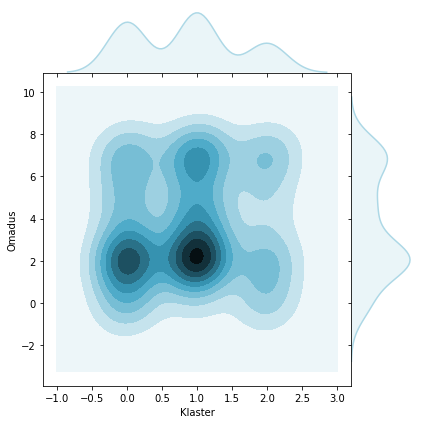

In [39]:
#Tulemuste visualiseerimine jointploti abil, millelt on võimalik jälgida klastri kuuluvuse ja kõrgeima skoori omavahelisi seoseid
sns.jointplot(x=df_plot_analyys["Klaster"], y=df_plot_analyys["Omadus"], kind='kde', color="lightblue", space = 0, stat_func = None)

In [40]:
#Vastajate koondumine arvuliselt. Loodud on Matplotlibi abil heatmap
import matplotlib.pyplot as plt
sns.set()

In [41]:
#Arvutatakse vastajate arvud (mitu inimest on selles klastris selle kõrgeima omadusega esindatud), mis kuvatakse heatmapil lahtrite sees
counts = pd.crosstab(df_plot_analyys.Klaster, df_plot_analyys.Omadus)

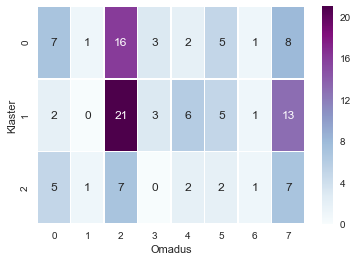

In [42]:
sns.heatmap(counts, annot=True, cmap='BuPu', linewidths=.5)